Consider a current $I$ flowing counterclockwise in a loop in the xy-plane with a 3-petal shape as follows:

$$\vec{l}(t) = R\left[1+\frac{3}{4}\sin(3 t)\right] \cdot \left<\cos t, \sin t, 0 \right> $$

where $0 \leq t \leq 2\pi$. The Biot-Savard Law tells us

$$\vec{B}(\vec{r}) =  \frac{\mu_0 I}{4 \pi} \int_C \frac{d\vec{l} \times (\vec{r}-\vec{l})}{|\vec{r}-\vec{l}|^3} = \int_0^{2 \pi} \frac{d\vec{l}/dt \times (\vec{r} - \vec{l})}{|\vec{r}-\vec{l}|^3} dt$$

Putting this in dimensionless form

* $\vec{l} \to \vec{l}/R$
* $\vec{r} \to \vec{r}/R$

we get

$$\frac{4 \pi R}{\mu_0 I} \vec{B}(\vec{r}) = \int_0^{2 \pi} \frac{d\vec{l}/dt \times (\vec{r} - \vec{l})}{|\vec{r}-\vec{l}|^3} dt$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, quad_vec
import plotly.graph_objects as go
import plotly.io as pio
from scipy import integrate
pio.renderers.default = 'iframe'
from IPython.display import HTML
import sympy as smp
from sympy.vector import cross

Start by looking at curve

In [2]:
phi = np.linspace(0, 1, 100)

def l(phi, radius=1):
    return radius * np.array([np.cos(2*np.pi*phi), 2*np.sin(2*np.pi*phi), np.zeros(len(phi))])

def l2(t, length=1, direction=[1, 0, 0], start_point=[-1, 0, 0]):
    direction = np.array(direction)
    # Normalize the direction vector
    direction = direction / np.linalg.norm(direction)
    # Create line in the specified direction starting at the specified point
    start_point = np.array(start_point).reshape(3, 1)
    line = start_point + length * np.array([
        direction[0] * t,
        direction[1] * t,
        direction[2] * t
    ])
    return line


In [3]:
lx, ly, lz = l(phi, radius=2)
l2x,l2y,l2z = l2(phi, length=2, direction=[1,0,0])

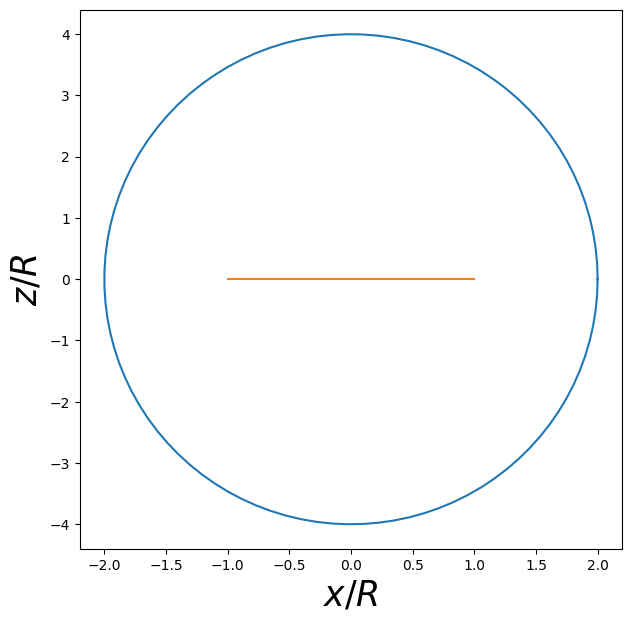

In [4]:
plt.figure(figsize=(7,7))
plt.plot(lx, ly)
plt.plot(l2x, l2y)
plt.xlabel('$x/R$', fontsize=25)
plt.ylabel('$z/R$', fontsize=25)
plt.show()

Lets solve for the integrand using sympy

In [25]:
t, x, y, z = smp.symbols('t, x, y, z')

Get $l$, $r$, and the seperation vector $\vec{r} - \vec{l}$

In [26]:
#l = 2*smp.Matrix([smp.cos(t), smp.sin(t), 0])
l = smp.Matrix([-1+2*t,0,0])
r = smp.Matrix([x, y, z])
sep = r-l

In [27]:
l

Matrix([
[2*t - 1],
[      0],
[      0]])

Define the integrand

In [28]:
sep

Matrix([
[-2*t + x + 1],
[           y],
[           z]])

In [29]:
#integrand = smp.diff(l, t).cross(sep) / sep.norm()**3
integrand = (smp.diff(l,t).cross(sep)) / sep.norm()**3

In [30]:
integrand

Matrix([
[                                                         0],
[-2*z/(Abs(y)**2 + Abs(z)**2 + Abs(-2*t + x + 1)**2)**(3/2)],
[ 2*y/(Abs(y)**2 + Abs(z)**2 + Abs(-2*t + x + 1)**2)**(3/2)]])

Get the $x$, $y$, and $z$ components of the integrand

In [31]:
dBxdt = smp.lambdify([t, x, y, z], integrand[0])
dBydt = smp.lambdify([t, x, y, z], integrand[1])
dBzdt = smp.lambdify([t, x, y, z], integrand[2])

Get the magnetic field by performing the integral over each component

In [32]:
"""
def B(x, y, z):
    return np.array([quad_vec(dBxdt, 0, 1, args=(x, y, z))[0],
                     quad_vec(dBydt, 0, 1, args=(x, y, z))[0],
                     quad_vec(dBzdt, 0, 1, args=(x, y, z))[0]])
"""

def B(x, y, z):
    Bx = np.zeros_like(x) + quad_vec(dBxdt, 0, 1, args=(x, y, z))[0]
    By = np.zeros_like(y) + quad_vec(dBydt, 0, 1, args=(x, y, z))[0]
    Bz = np.zeros_like(z) + quad_vec(dBzdt, 0, 1, args=(x, y, z))[0]
    
    return np.array([Bx,
                     By,
                     Bz])

Set up a meshgrid to solve for the field in some 3D volume

In [33]:
x = np.linspace(-2, 2, 20)
xv, yv, zv = np.meshgrid(x, x, x)

In [37]:
B_field = B(xv, yv, zv)
Bx, By, Bz = B_field

In [38]:
Bx[Bx>20] = 20
By[By>20] = 20
Bz[Bz>20] = 20

Bx[Bx<-20] = -20
By[By<-20] = -20
Bz[Bz<-20] = -20

Use plotly to make an interactive 3D plot

In [39]:
data = go.Cone(x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
               u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
               colorscale='Inferno', colorbar=dict(title='$x^2$'),
               sizemode="absolute", sizeref=20)

layout = go.Layout(title=r'Plot Title',
                     scene=dict(xaxis_title=r'x',
                                yaxis_title=r'y',
                                zaxis_title=r'z',
                                aspectratio=dict(x=1, y=1, z=1),
                                camera_eye=dict(x=1.2, y=1.2, z=1.2)))

fig = go.Figure(data = data, layout=layout)
fig.add_scatter3d(x=lx, y=ly, z=lz, mode='lines',
                  line = dict(color='green', width=10))
fig.add_scatter3d(x=l2x, y=l2y, z=l2z, mode='lines',
                  line = dict(color='green', width=10))